In [1]:
import matplotlib.pyplot as plt
import sigpy.mri as mr
import torch
import torch.fft
import h5py
import numpy as np
import os
import glob

/home/jgarca2/miniconda3/envs/bioe_dl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SamplingFunction(torch.nn.Module):
    def __init__(self, accel_factor=2, num_central_lines=32):
        super().__init__()
        self.accel_factor = accel_factor
        self.num_central_lines = num_central_lines
        self.ky_positions = None  # Will store as tensor when available
        self.target_shape = None  # Store as tuple

    @staticmethod
    def normalize_complex_data(data):
        """Normalize complex data to [0,1] range"""
        data = (data - torch.mean(data)) / (torch.std(data) + 1e-8)
        mag = torch.abs(data)
        return data / (torch.max(mag) + 1e-8)

    @staticmethod
    def normalize_sensitivity_maps(Cs):
        """Normalize coil sensitivity maps"""
        if isinstance(Cs, torch.Tensor):
            return Cs / (torch.sqrt(torch.sum(torch.abs(Cs)**2, dim=0, keepdim=True)) + 1e-8)
        elif isinstance(Cs, np.ndarray):
            return Cs / (np.sqrt(np.sum(np.abs(Cs)**2, axis=0, keepdims=True)) + 1e-8)
        else:
            raise TypeError("Input must be either torch.Tensor or numpy.ndarray")

    def create_mask(self, kx, ky):
        """Create sampling mask with central lines + acceleration"""
        mask = torch.zeros((kx, ky), dtype=torch.bool)
        center = ky // 2
        half_width = self.num_central_lines // 2

        # Central lines
        central_lines = slice(center - half_width, center + half_width + (self.num_central_lines % 2))
        mask[:, central_lines] = True

        # Acceleration lines (avoid duplicates)
        all_lines = torch.arange(ky)
        accel_lines = all_lines[::self.accel_factor]
        exclude_range = torch.arange(center - half_width, center + half_width + 1)
        accel_lines = accel_lines[~torch.isin(accel_lines, exclude_range)]

        mask[:, accel_lines] = True
        sampled_positions = torch.where(mask[0])[0]
        return mask, sampled_positions

    def apply_mask(self, kspace_data, normalize=False):
        """Apply mask to k-space data with optional normalization"""
        if isinstance(kspace_data, np.ndarray):
            kspace_data = torch.from_numpy(kspace_data)

        mask, positions = self.create_mask(kspace_data.shape[-2], kspace_data.shape[-1])
        self.ky_positions = positions
        self.target_shape = tuple(kspace_data.shape)

        undersampled = kspace_data[..., mask[0]]
        return (self.normalize_complex_data(undersampled) if normalize else undersampled,
                positions,
                mask)

    def zero_fill(self, undersampled_ksp, normalize=False):
        """Zero-fill with optional normalization"""
        if self.ky_positions is None or self.target_shape is None:
            raise ValueError("Run apply_mask() first")

        result = torch.zeros(self.target_shape,
                            dtype=undersampled_ksp.dtype)
        result[..., self.ky_positions] = undersampled_ksp
        return self.normalize_complex_data(result) if normalize else result

In [3]:
class Physics(torch.nn.Module):
    def __init__(self, alpha=0.1, sampler=None):
        super().__init__()
        self.alpha = alpha
        self.sampler = sampler  # SamplingFunction instance

    def forward(self, x):
        return x

    def fourier_transform(self, img, dim=(-2, -1)):
        """Image → k-space (orthonormal FFT)."""
        img = torch.fft.ifftshift(img, dim=dim)
        k = torch.fft.fftn(img, dim=dim, norm='ortho')
        return torch.fft.fftshift(k, dim=dim)

    def inverse_fourier_transform(self, k, dim=(-2, -1)):
        """k-space → image (orthonormal FFT)."""
        k = torch.fft.ifftshift(k, dim=dim)
        img = torch.fft.ifftn(k, dim=dim, norm='ortho')
        return torch.fft.fftshift(img, dim=dim)

    def _compute_S(self, C_k, Cs):
        """
        Compute S = C_k - alpha * Eᴴ(E(C_k))
        """
        Cs_conj = torch.conj(Cs)
        # E(C_k) = Masked FFT(C_k * Cs)
        C_x = C_k * Cs  # [B, 15, H, W]
        CF_x = self.fourier_transform(C_x)  # [B, 15, H, W]
        E_x, _, _ = self.sampler.apply_mask(CF_x, normalize=False)  # [B, 15, H, W_ksp]
        # Eᴴ(E_x) = IFFT(zero-filled E_x) * Csᴴ
        Z_Ex = self.sampler.zero_fill(E_x, normalize=False)  # [B, 15, H, W]
        IFZ_Ex = self.inverse_fourier_transform(Z_Ex)  # [B, 15, H, W]
        Eh_Ex = Cs_conj * IFZ_Ex  # [B, 15, H, W]
        return C_k - self.alpha * Eh_Ex

    def _compute_W_e(self, undersampled_ksp, Cs):
        """
        Compute W_e = alpha * Eᴴ(undersampled_ksp)
        """
        Cs_conj = torch.conj(Cs)
        Z_x = self.sampler.zero_fill(undersampled_ksp, normalize=False)  # [B, 1, H, W]
        IFZ_x = self.inverse_fourier_transform(Z_x)  # [B, 1, H, W]
        return self.alpha * Cs_conj * IFZ_x

    def _final_sum(self, S, W_e):
        """
        Combine S and W_e with sum-of-squares (SOS) normalization.
        """
        combined = S + W_e
        combined_sos = torch.sum(combined, dim=-3)  # [B, 1, H, W]
        return combined_sos

### Preprocesing of the k-space information

In [ ]:
# Path to directory containing training files
input_dir = r'/shared/BIOE486/SP25/users/jgarca2/Dataset/multicoil_train'

train_files = glob.glob(os.path.join(input_dir, '*.h5'))

# Base output path (matches your example)
base_output_path = '/shared/BIOE486/SP25/users/jgarca2/Dataset/multicoil_train_preprocessing'

# Check existence of the patient number
existing_patients = []
if os.path.exists(base_output_path):
    existing_patients = [d for d in os.listdir(base_output_path)
                       if os.path.isdir(os.path.join(base_output_path, d)) and d.isdigit()]
start_num = max([int(num) for num in existing_patients] + [0]) + 1


# Process each patient file
for patient_num, fname_train in enumerate(train_files, start=start_num):
    # Create patient directory (e.g., "PreprocessedMC4fold/multicoil_train/1")
    patient_dir = os.path.join(base_output_path, str(patient_num))

    # Create subdirectories for this patient
    subfolders = {
        'ground_truth': os.path.join(patient_dir, 'ground_truth'),
        'undersample': os.path.join(patient_dir, 'undersample'),
        'zerofill': os.path.join(patient_dir, 'zerofill'),
        'coil_sensitivity': os.path.join(patient_dir, 'coil_sensitivity'),
        'ground_truth_Cs': os.path.join(patient_dir, 'ground_truth_Cs')
    }

    for folder in subfolders.values():
        os.makedirs(folder, exist_ok=True)

    # Load data
    with h5py.File(fname_train, 'r') as f:
        kspace = np.array(f['kspace'])  # (num_slice, num_coil, H, W)
        gt = np.array(f['reconstruction_rss'])  # (num_slice, H, W)

    # Initialize sampling
    sampler = SamplingFunction(accel_factor=4, num_central_lines=30)
    physics = Physics(alpha=0.1, sampler=sampler)

    # Process slices
    for slice_idx in range(kspace.shape[0]):
        # Undersampled k-space
        undersample, _, _ = sampler.apply_mask(kspace[slice_idx])

        # Zero-filled
        zerofilled = sampler.zero_fill(undersample)

        # Coil sensitivities
        zerofilled_np = zerofilled.cpu().numpy() if isinstance(zerofilled, torch.Tensor) else zerofilled
        Cs = mr.app.EspiritCalib(zerofilled_np).run()
         sensitivities = Cs / np.sqrt(np.sum(np.abs(Cs)**2, axis=0, keepdims=True) + 1e-8)
        sensitivities_conj = torch.conj(torch.from_numpy(sensitivities))

        # Zero-filled reconstruction
        zf_recon = physics.inverse_fourier_transform(zerofilled)
        zf_Cs = torch.sum(zf_recon * sensitivities_conj, dim = -3)

        # Ground-truth reconstruction
        ksp_tensor = torch.from_numpy(kspace[slice_idx])
        gt_recon = physics.inverse_fourier_transform(ksp_tensor)
        gt_Cs = torch.sum(gt_recon * sensitivities_conj, dim = -3)

        #zf_sos = torch.sqrt(torch.sum(torch.abs(zf_recon)**2, dim=-3))
        # Save all components
        np.save(os.path.join(subfolders['ground_truth'], f'{slice_idx}.npy'), gt[slice_idx])
        np.save(os.path.join(subfolders['ground_truth_Cs'], f'{slice_idx}.npy'), gt_Cs.cpu().numpy())
        np.save(os.path.join(subfolders['undersample'], f'{slice_idx}.npy'), undersample.cpu().numpy())
        np.save(os.path.join(subfolders['zerofill'], f'{slice_idx}.npy'), zf_Cs.cpu().numpy())
        np.save(os.path.join(subfolders['coil_sensitivity'], f'{slice_idx}.npy'), sensitivities)

    print(f"Patient {patient_num} processed: {os.path.basename(fname_train)}")

EspiritCalib: 100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


Patient 1 processed: file1000873.h5


EspiritCalib: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


### Data after preprocessing :

Note that data is not always in the center and crop for all images in the same position don't always work. Then we need a function crop in the center.

gt_slice.shape (320, 320), gt_Cs_slice.shape (640, 644), zf_Cs_slice.shape (640, 644), sensitivities_slice.shape (15, 640, 644), undersample_slice.shape (15, 640, 183)


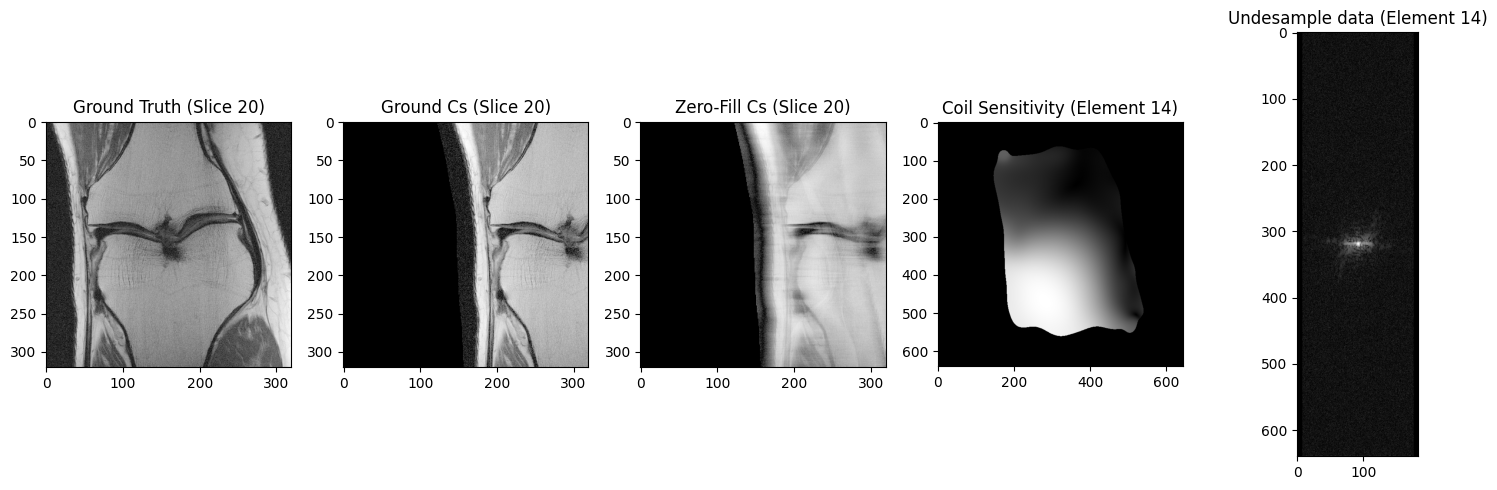

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os

base_dir = r"/shared/BIOE486/SP25/users/jgarca2/Dataset/multicoil_val_preprocessing/10"
subfolders = {
    'ground_truth': os.path.join(base_dir, 'ground_truth'),
    'ground_truth_Cs': os.path.join(base_dir, 'ground_truth_Cs'),
    'undersample': os.path.join(base_dir, 'undersample'),
    'zerofill': os.path.join(base_dir, 'zerofill'),
    'coil_sensitivity': os.path.join(base_dir, 'coil_sensitivity')
}

slice_num = 20
index = 5

# Load data for the selected slice
gt = np.load(os.path.join(subfolders['ground_truth'], f'{slice_num}.npy'))
gt_Cs = np.load(os.path.join(subfolders['ground_truth_Cs'], f'{slice_num}.npy'))
undersample_slice = np.load(os.path.join(subfolders['undersample'], f'{slice_num}.npy'))
zf_Cs_slice = np.load(os.path.join(subfolders['zerofill'], f'{slice_num}.npy'))
sensitivities_slice = np.load(os.path.join(subfolders['coil_sensitivity'], f'{slice_num}.npy'))

print(f'gt_slice.shape {gt.shape}, gt_Cs_slice.shape {gt_Cs.shape}, zf_Cs_slice.shape {zf_Cs_slice.shape}, sensitivities_slice.shape {sensitivities_slice.shape}, undersample_slice.shape {undersample_slice.shape}')

def safe_plot(data, epsilon = 1e-5):
    return np.log(np.abs(data) + epsilon)
index = 14
# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(safe_plot(gt), cmap='gray')
axes[0].set_title(f'Ground Truth (Slice {slice_num})')
axes[1].imshow(safe_plot(gt_Cs[160:480, 25:345]), cmap='gray')
axes[1].set_title(f'Ground Cs (Slice {slice_num})')

axes[2].imshow(safe_plot(zf_Cs_slice[160:480, 25:345]), cmap='gray')
axes[2].set_title(f'Zero-Fill Cs (Slice {slice_num})')
axes[3].imshow(safe_plot(sensitivities_slice[index],1e-1), cmap='gray')  # First coil's sensitivity
axes[3].set_title(f'Coil Sensitivity (Element {index})')
axes[4].imshow(safe_plot(undersample_slice[index]), cmap = 'gray')
axes[4].set_title(f'Undesample data (Element {index})')

plt.tight_layout()
plt.show()

### Implemenetation of the function that will be used in the dataset and dataloader : 

Crop in the middle. In this case I apply this function to the zero-fill Cs and Coil sensitivity. Notice the zero-fill now is in the middle and look similar to the ground true provid it in the dataset.

In [24]:
def extract_central_patch(x: torch.Tensor, patch_size: int = 320) -> torch.Tensor:
    H = x.shape[-2]
    W = x.shape[-1]
    start_x = (H - patch_size) // 2
    start_y = (W - patch_size) // 2
    return x[..., start_x:start_x + patch_size, start_y:start_y + patch_size]

gt_slice.shape (320, 320), gt_Cs_slice.shape (640, 644), zf_Cs_slice.shape (640, 644), sensitivities_slice.shape (15, 640, 644), undersample_slice.shape (15, 640, 183)


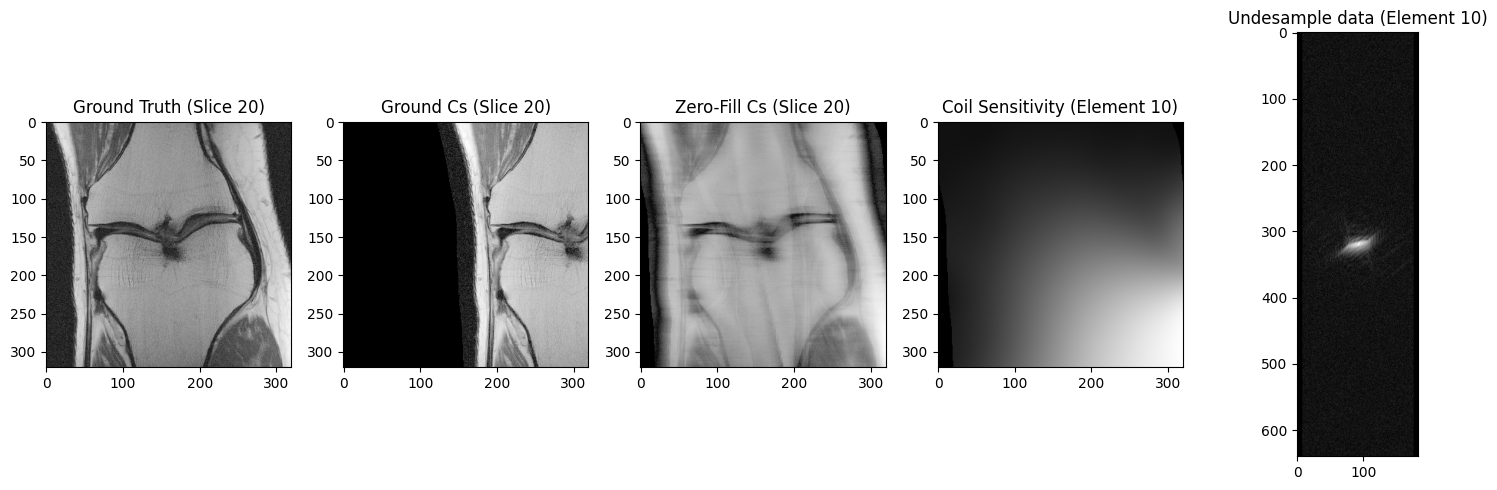

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os

base_dir = r"/shared/BIOE486/SP25/users/jgarca2/Dataset/multicoil_val_preprocessing/10"
subfolders = {
    'ground_truth': os.path.join(base_dir, 'ground_truth'),
    'ground_truth_Cs': os.path.join(base_dir, 'ground_truth_Cs'),
    'undersample': os.path.join(base_dir, 'undersample'),
    'zerofill': os.path.join(base_dir, 'zerofill'),
    'coil_sensitivity': os.path.join(base_dir, 'coil_sensitivity')
}

slice_num = 20
index = 5

# Load data for the selected slice
gt = np.load(os.path.join(subfolders['ground_truth'], f'{slice_num}.npy'))
gt_Cs = np.load(os.path.join(subfolders['ground_truth_Cs'], f'{slice_num}.npy'))
undersample_slice = np.load(os.path.join(subfolders['undersample'], f'{slice_num}.npy'))
zf_Cs_slice = np.load(os.path.join(subfolders['zerofill'], f'{slice_num}.npy'))
zf_Cs_slice_torch = torch.from_numpy(zf_Cs_slice)
sensitivities_slice = np.load(os.path.join(subfolders['coil_sensitivity'], f'{slice_num}.npy'))
sensitivities_slice_torch = torch.from_numpy(sensitivities_slice)

print(f'gt_slice.shape {gt.shape}, gt_Cs_slice.shape {gt_Cs.shape}, zf_Cs_slice.shape {zf_Cs_slice.shape}, sensitivities_slice.shape {sensitivities_slice.shape}, undersample_slice.shape {undersample_slice.shape}')

def safe_plot(data, epsilon = 1e-5):
    return np.log(np.abs(data) + epsilon)
index = 10
# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(safe_plot(gt), cmap='gray')
axes[0].set_title(f'Ground Truth (Slice {slice_num})')
#axes[1].imshow(safe_plot(zf_Cs_slice[160:480, 25:345]), cmap='gray')
axes[1].imshow(safe_plot(gt_Cs[160:480, 25:345]), cmap='gray')
axes[1].set_title(f'Ground Cs (Slice {slice_num})')

axes[2].imshow(safe_plot(extract_central_patch(zf_Cs_slice_torch)), cmap='gray')
axes[2].set_title(f'Zero-Fill Cs (Slice {slice_num})')
axes[3].imshow(safe_plot(extract_central_patch(sensitivities_slice_torch)[index],1e-1), cmap='gray')  # First coil's sensitivity
axes[3].set_title(f'Coil Sensitivity (Element {index})')
axes[4].imshow(safe_plot(undersample_slice[index]), cmap = 'gray')
axes[4].set_title(f'Undesample data (Element {index})')

plt.tight_layout()
plt.show()
